# Data Sharing with Encryption - Delentture side

### Recommended 

Create conda enviroment to avoid conflicts with packages.

### Installs

In [ ]:
!pip uninstall -y pycrypto
!pip install pycryptodome
!pip install seaborn

### Imports & W/R byte functions

In [ ]:
from Crypto.Cipher import AES
from Crypto import Random
from cryptography.hazmat.backends import default_backend
import socket

HOST = "127.0.0.1"  # The server's hostname or IP address
PORT = 65432  

# get current directory
path = os.getcwd()
parent = os.path.dirname(path)

DIR_DATA = parent+ '/data/'

def write_file(data,filename):
    with open(filename, 'wb') as f:
        f.write(data)
        f.close()

def read_file(filename):
    with open(filename, 'rb') as f:
        data_b = f.read()
        f.close()
    return data_b


### Public Key Exchange

#### DH (Diffie–Hellman)

In [ ]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.serialization import Encoding, PublicFormat,load_der_public_key

p = 0xFFFFFFFFFFFFFFFFC90FDAA22168C234C4C6628B80DC1CD129024E088A67CC74020BBEA63B139B22514A08798E3404DDEF9519B3CD3A431B302B0A6DF25F14374FE1356D6D51C245E485B576625E7EC6F44C42E9A637ED6B0BFF5CB6F406B7EDEE386BFB5A899FA5AE9F24117C4B1FE649286651ECE45B3DC2007CB8A163BF0598DA48361C55D39A69163FA8FD24CF5F83655D23DCA3AD961C62F356208552BB9ED529077096966D670C354E4ABC9804F1746C08CA18217C32905E462E36CE3BE39E772C180E86039B2783A2EC07A28FB5C55DF06F4C52C9DE2BCBF6955817183995497CEA956AE515D2261898FA051015728E5A8AACAA68FFFFFFFFFFFFFFFF
g = 2

params_numbers = dh.DHParameterNumbers(p,g)
parameters = params_numbers.parameters(default_backend())

In [ ]:
def dh_key_exchange(params):
    key_B = parameters.generate_private_key() # red
    public_mix_B  = key_B.public_key().public_bytes(Encoding.DER, PublicFormat.SubjectPublicKeyInfo)  #orange
    
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        public_mix_A = s.recv(1024)
        print(f'Received public key in bytes from Controler {public_mix_A}')
        s.sendall(public_mix_B)
        
    public_mix_A_ser = load_der_public_key(public_mix_A,backend = default_backend())
    shared_key = key_B.exchange(public_mix_A_ser)

    derived_key = HKDF(
        algorithm = hashes.SHA256(),
        length=32,
        salt=None,
        info=b'handshake data',
        backend=default_backend()
    ).derive(shared_key)

    return derived_key

In [ ]:
dh_key = dh_key_exchange(parameters)
dh_key

**Action #2** -> Run all the upper cells

#### RSA (Rivest–Shamir–Adleman)

In [ ]:
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding

### De-encryption

#### HMAC

In [ ]:
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import cmac, hashes, hmac
import os

key_1 = b'\xb6\xb3\xe8\xb2\x10\x07\xf9\x82\xb6\xfb\xdc\xf5\xc2\xcd\x1d\xd6I\x83\xd6\xf0)w\xaawV8\x93SH&C\xf7'
key_2 = b'$C&F)J@NcRfUjXnZ'

In [ ]:
h = hmac.HMAC(key_2, hashes.SHA256())
h.update(ciphertext)
h.verify(signature)

#### AES (ECB)

In [ ]:
def decrypt_image_ecb(data, key, iv=b''):
    
    block_size = AES.block_size
    padding_length = block_size - len(data) % block_size # Calculate padding_length to make len(image array) a multiple of block_size
    data += bytes(padding_length * ".", "UTF-8") # Just an arbitrary padding byte

    mode   = AES.MODE_ECB
    aes    = AES.new(key, mode)

    decrypted_data = aes.decrypt(data) # Your code to decrypt image_array using AES

    return decrypted_data

#### AES (CBC)

### EDA (Exploratory Data Analysis)

In [ ]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200

In [ ]:
df_columns = pd.read_csv(DIR_DATA+'columns_description.csv')
df_loans = pd.read_csv(DIR_DATA+'infringement_dataset.csv')

#### Data Description

In [75]:
df_columns.head()

,New name,Description
0,address,Client's address
1,age,Client's age in days at the time of application
2,annual_income,Income of the client
3,appendix_a,Did client provide document 2
4,appendix_b,Did client provide document 3


In [76]:
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   New name     67 non-null     object
 1   Description  67 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [77]:
df_loans.head()

,loan_id,infringed,contract_type,gender,has_own_car,has_own_realty,num_children,annual_income,credit_amount,credit_annuity,...,SK_ID_CURR,avg_days_decision,past_avg_amount_annuity,past_avg_amt_application,past_avg_amt_credit,past_loans_approved,past_loans_refused,past_loans_canceled,past_loans_unused,past_loans_total
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,100002.0,606.000000,9251.775,179055.00,179055.00,1.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,100003.0,1305.000000,56553.990,435436.50,484191.00,3.0,0.0,0.0,0.0,3.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,100004.0,815.000000,5357.250,24282.00,20106.00,1.0,0.0,0.0,0.0,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,100006.0,272.444444,23651.175,272203.26,291695.50,5.0,3.0,1.0,0.0,9.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,100007.0,1222.833333,12278.805,150530.25,166638.75,6.0,0.0,0.0,0.0,6.0


In [78]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 69 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   loan_id                   307511 non-null  int64  
 1   infringed                 307511 non-null  int64  
 2   contract_type             307511 non-null  object 
 3   gender                    307511 non-null  object 
 4   has_own_car               307511 non-null  object 
 5   has_own_realty            307511 non-null  object 
 6   num_children              307511 non-null  int64  
 7   annual_income             307511 non-null  float64
 8   credit_amount             307511 non-null  float64
 9   credit_annuity            307499 non-null  float64
 10  goods_valuation           307233 non-null  float64
 11  income_type               307511 non-null  object 
 12  education                 307511 non-null  object 
 13  family_status             307511 non-null  o

In [79]:
df_loans['infringed'].value_counts()

0    282686
1     24825
Name: infringed, dtype: int64

In [80]:
df_loans['gender'].value_counts()

F      202448
M      105059
XNA         4
Name: gender, dtype: int64

In [81]:
df_loans['contract_type'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: contract_type, dtype: int64

In [82]:
regex = 'past_.*'

cond_regex = df_columns['New name'].str.match(regex)
result = df_columns[cond_regex]
cols = result['New name'].tolist()
cols += ['infringed']

cols

['past_avg_amount_annuity',
 'past_avg_amt_application',
 'past_avg_amt_credit',
 'past_loans_approved',
 'past_loans_canceled',
 'past_loans_refused',
 'past_loans_total',
 'past_loans_unused',
 'infringed']

In [83]:
cond = df_columns['New name'].isin(cols)
df_columns.loc[cond]

,New name,Description
37,infringed,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
51,past_avg_amount_annuity,Average amount of annuity in past loans for the client
52,past_avg_amt_application,Average amount of credit applied in past loans by the client
53,past_avg_amt_credit,Average amount of credit conceded in past loans for the client
54,past_loans_approved,Number of loans approved in the past for the client
55,past_loans_canceled,Number of loans canceled in the past for the client
56,past_loans_refused,Number of loans refused in the past for the client
57,past_loans_total,"Number of loans in the past for the client, regardless of the outcome"
58,past_loans_unused,Number of loans approved but not used in the past for the client


<AxesSubplot: xlabel='gender', ylabel='count'>

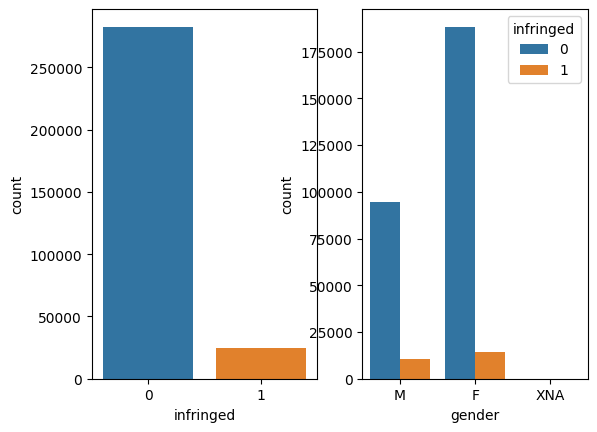

In [84]:
fig, axes = plt.subplots(1, 2)

sb.countplot(data=df_loans, x="infringed", ax= axes[0])
sb.countplot(x ='gender', hue = "infringed", data = df_loans, ax= axes[1])

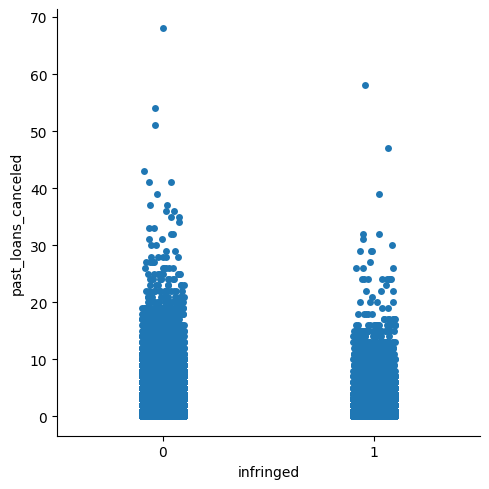

In [92]:
sb.catplot(data=df_loans, x="infringed", y="past_loans_canceled")

In [ ]:
cond = df_loans['infringed'] == 1
df_infriged = df_loans[cond]
df_infriged.head()


In [ ]:
sb.lineplot(data=df_loans, x="timepoint", y="signal", hue="event")